<a href="https://colab.research.google.com/github/robert-myers/you-had-me-at-hello/blob/master/notebooks/movie_script_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import codecs
import random
import nltk
import re
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib.colors import LogNorm
from matplotlib.ticker import FixedLocator, FixedFormatter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.cluster import MiniBatchKMeans, KMeans, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
from scipy.spatial import distance
from sklearn.mixture import GaussianMixture

In [2]:
nltk.download(['stopwords', 'wordnet', 'punkt'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
df = pd.read_csv("https://media.githubusercontent.com/media/robert-myers/you-had-me-at-hello/master/data/moviequotes.scripts.txt",
                 encoding="ISO-8859-1",
                 sep=" \+\+\+\$\+\+\+ ",
                 engine="python",
                 names=["LINE_ID", "MOVIE_TITLE", "MOVIE_LINE_NR", "CHARACTER", "REPLY_TO_LINE_ID", "TEXT"],
                 index_col=0,
                #  warn_bad_lines=False,
                #  error_bad_lines=False,
                 )

In [0]:
df["TEXT"] = df["TEXT"].apply(lambda x: x if x else "")

In [5]:
random_idx = random.randint(0, len(df)-5)
df.loc[random_idx:random_idx+4]

,MOVIE_TITLE,MOVIE_LINE_NR,CHARACTER,REPLY_TO_LINE_ID,TEXT
LINE_ID,,,,,
6855,a few good men,337,kaffee,6854,"If you can't beat 'em, join 'em."
6856,a few good men,338,luther,6855,"Hey, if you've got your health, you got everyt..."
6857,a few good men,339,kaffee,6856,Love makes the world go round. I'll see you to...
6858,a few good men,340,sam,NaN,"When Nancy gets back, you're my witness. The b..."
6859,a few good men,341,kaffee,6858,"Your daughter made a sound, Sam, I'm not sure ..."


In [0]:
gb = df.groupby("MOVIE_TITLE")
corpora_dct = {}
for group in gb.groups:
  key = gb.get_group(group)["MOVIE_TITLE"].unique()[0]
  corpora_dct[key] = gb.get_group(group)
corpora_dct = {movie_title: " ".join(script_df["TEXT"]) for movie_title, script_df in corpora_dct.items()}
corpora = pd.Series(corpora_dct).reset_index()
corpora = corpora.rename(columns={"index": "movie_title", 0:"script"}).set_index("movie_title")

In [7]:
corpora

,script
movie_title,
"""murderland""","Ladies and gentlemen, the official mascot of M..."
10 things i hate about you,Hey -- sorry. Leave it Did you change your hai...
1492: conquest of paradise,Your Majesty would wish to know the true facts...
15 minutes,Just do what I do. Say the same thing I say. ...
2001: a space odyssey,"AFRICA 3,000,000 YEARS AGO -------------------..."
...,...
you've got mail,Good morning. Listen to this -- the entire wor...
young frankenstein,Fumbling fool! For two kronen I'd rip that bo...
youth in revolt,"My name... is Nick. My last name, which I loat..."


In [0]:
stop_words = set(stopwords.words("english"))

def rm_stop_and_tokenize(x, join=True, remove_stop=True):
  x = re.sub('\W+', ' ', x)
  wnl = WordNetLemmatizer()
  ps = PorterStemmer()
  if remove_stop:
    string = " ".join([wnl.lemmatize(ps.stem(word)).lower() for word in x.split() if word.lower() not in stop_words])
  else:
    string = " ".join([wnl.lemmatize(ps.stem(word)).lower() for word in x.split()])
  tokens = word_tokenize(string)
  if join:
    return " ".join(tokens)
  return tokens

In [0]:
corpora["tokenized"] = corpora["script"].apply(lambda x: rm_stop_and_tokenize(x))

In [10]:
corpora

,script,tokenized
movie_title,,
"""murderland""","Ladies and gentlemen, the official mascot of M...",ladi gentleman offici mascot murderland scrap ...
10 things i hate about you,Hey -- sorry. Leave it Did you change your hai...,hey sorri leav chang hair might wan na think h...
1492: conquest of paradise,Your Majesty would wish to know the true facts...,majesti would wish know true fact concern isla...
15 minutes,Just do what I do. Say the same thing I say. ...,say thing say open mouth okay fool around okay...
2001: a space odyssey,"AFRICA 3,000,000 YEARS AGO -------------------...",africa 3 000 000 year ago a1 view african dryl...
...,...,...
you've got mail,Good morning. Listen to this -- the entire wor...,good morn listen entir work forc state virgini...
young frankenstein,Fumbling fool! For two kronen I'd rip that bo...,fumbl fool two krone rip box fight hand shhh h...
youth in revolt,"My name... is Nick. My last name, which I loat...",name nick last name loath twisp next thing kno...


In [0]:
X = Pipeline([
              ("vect", CountVectorizer(max_features=962, ngram_range=(1,3))),
              ("tfidf", TfidfTransformer(use_idf=False)),
              ("to_dense", FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),
              ])
X = X.fit_transform(corpora["tokenized"])

In [12]:
range_n_clusters = range(2,9)

for n_clusters in range_n_clusters:
  kmeans = KMeans(n_clusters=n_clusters)
  cluster_labels = kmeans.fit_predict(X)

  silhouette_avg = silhouette_score(X, cluster_labels)
  print("For n_clusters =", n_clusters,
        "The average silhouette_score is :", silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.09125611906937699
For n_clusters = 3 The average silhouette_score is : 0.048069064070580425
For n_clusters = 4 The average silhouette_score is : 0.04037415544191504
For n_clusters = 5 The average silhouette_score is : 0.025838270267905524
For n_clusters = 6 The average silhouette_score is : 0.022422719368333732
For n_clusters = 7 The average silhouette_score is : 0.020696652463980475
For n_clusters = 8 The average silhouette_score is : 0.021416186101949772


In [13]:
X.shape

(1068, 962)

In [0]:
kmeans = KMeans(n_clusters=2)
cluster_labels = kmeans.fit_predict(X)

In [0]:
euc_arr0 = []
euc_arr1 = []
# euc_arr2 = []
for movie in X:
  euc_arr0.append(distance.euclidean(movie, kmeans.cluster_centers_[0]))
  euc_arr1.append(distance.euclidean(movie, kmeans.cluster_centers_[1]))
  # euc_arr2.append(distance.euclidean(movie, kmeans.cluster_centers_[2]))
euc_arr0 = np.array(euc_arr0)
euc_arr1 = np.array(euc_arr1)
# euc_arr2 = np.array(euc_arr2)

In [16]:
kmeans.cluster_centers_

array([[0.00791303, 0.00461243, 0.00534109, ..., 0.01799171, 0.00390327,
        0.01746936],
       [0.00662497, 0.00478238, 0.00303519, ..., 0.01328463, 0.00609378,
        0.00952315]])

In [17]:
np.mean(euc_arr0), np.mean(euc_arr1),# np.mean(euc_arr2)

(0.6190806636373231, 0.5796758852378003)

In [18]:
print(euc_arr0[euc_arr0.argsort()[:10]])

corpora.iloc[euc_arr0.argsort()[:10]]

[0.43768726 0.46100186 0.48198496 0.4855646  0.4860908  0.48697738
 0.48707267 0.48709124 0.48751572 0.48807173]


,script,tokenized
movie_title,,
being human,4000 Warner Boulevard WARNER BROS. INC. Burban...,4000 warner boulevard warner bro inc burbank c...
g,... last few years have brought many advances ...,last year brought mani advanc interest woman n...
real genius,A Black B-1 Bomber banks steeply exposing its ...,black b 1 bomber bank steepli expo undersid u ...
cinema paradiso,"...Salvatore, that's right, Salvatore. Di Vita...",salvator right salvator di vita salvator miss ...
sherlock holmes,The year was 1891. London was the capital of t...,year 1891 london capit world height modern his...
l'avventura,"So, there you are... I've been upstairs lookin...",upstair look oh thought alreadi high sea yet d...
"avventura, l' (the adventure)","So, there you are... I've been upstairs lookin...",upstair look oh thought alreadi high sea yet d...
bonfire of the vanities,Rev. 04/18/90 Rev. 04/25/90 Rev. 04/26/90 Rev....,rev 04 18 90 rev 04 25 90 rev 04 26 90 rev 05 ...
transatlantic merry-go-round,"Large ocean liner, plowing through darkened wa...",larg ocean liner plow darken water deck portho...


In [19]:
print(euc_arr1[euc_arr1.argsort()[:10]])

corpora.iloc[euc_arr1.argsort()[:10]]

[0.34979928 0.38104332 0.38640806 0.39324744 0.40043939 0.40234026
 0.40323733 0.4063535  0.40764389 0.40791921]


,script,tokenized
movie_title,,
nurse betty,"Close her up, will you? There's been a train c...",close train crash near santa barbara fli aorta...
good will hunting,"Oh my God, I got the most fucked up thing I be...",oh god got fuck thing meanin tell oh jesu go g...
taxi driver,No trouble with the Hack Bureau? No Sir. Got y...,troubl hack bureau sir got licens ye want taxi...
observe and report,"Ladies, please, we're doing everything we can ...",ladi plea everyth handl situat noth import u s...
body heat,"October 6, 1980 My God, it's hot. I stepped ou...",octob 6 1980 god hot step shower stare sweat s...
wild things,When we graduate the only thing I'm going to m...,graduat thing go miss know mean kelli oh yeah ...
superman iii,"Name? Gus Gorman. Ah yes, August Gorman. Have ...",name gu gorman ah ye august gorman look work w...
metro,...at the top of the stretch it's Cozy Girl in...,top stretch cozi girl front backtrack come coz...
strange days,Ready? Yeah. Boot it. Okay. It's goin'. I'm re...,readi yeah boot okay goin record good one dick...


In [0]:
# print(euc_arr2[euc_arr2.argsort()[:5]])

# corpora.iloc[euc_arr2.argsort()[:5]]

In [0]:
# pca = PCA(0.99)
# X_train_pca = pca.fit_transform(X)

In [22]:
k_range = range(5, 150, 5)
kmeans_per_k = []
for k in k_range:
    print("k={}".format(k))
    kmeans = KMeans(n_clusters=k).fit(X)
    kmeans_per_k.append(kmeans)

k=5
k=10
k=15
k=20
k=25
k=30
k=35
k=40
k=45
k=50
k=55
k=60
k=65
k=70
k=75
k=80
k=85
k=90
k=95
k=100
k=105
k=110
k=115
k=120
k=125
k=130
k=135
k=140
k=145


In [0]:
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

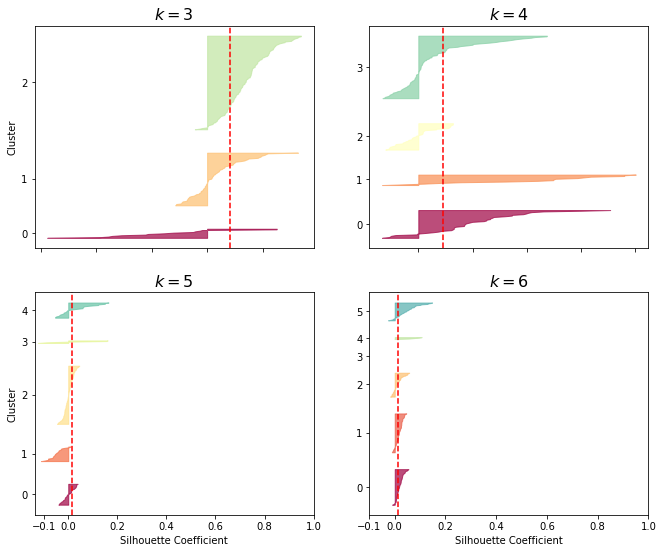

In [24]:
plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

# save_fig("silhouette_analysis_plot")
plt.show()

In [0]:
X2 = Pipeline([
              ("vect", CountVectorizer(max_features=2, ngram_range=(1,3))),
              ("tfidf", TfidfTransformer(use_idf=True)),
              ("to_dense", FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),
              ])
X2 = X2.fit_transform(corpora["tokenized"])

In [26]:
gm = GaussianMixture(n_components=3, n_init=10)
gm.fit(X2)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=10,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

In [0]:
def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)


In [0]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Log scale: values of z <= 0 have been masked
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Log scale: values of z <= 0 have been masked
  from ipykernel import kernelapp as app


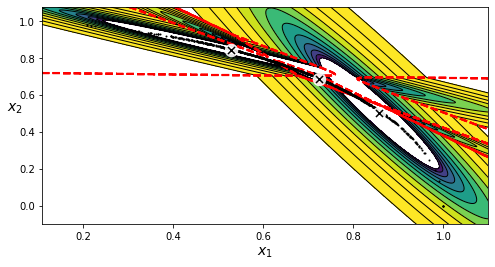

In [29]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X2)

# save_fig("gaussian_mixtures_plot")
plt.show()

In [30]:
X.shape

(1068, 962)